In [18]:
# import the necessary packages
from collections import deque
from imutils.video import VideoStream
import numpy as np
import argparse
import cv2
import imutils
from skimage.morphology import erosion, dilation, opening, closing
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from PIL import Image
from IPython.display import Image as IPImage, display
import itertools

print(cv2.__version__)

4.9.0


In [19]:
#Parameters
h_threshold = 120  # param
s_threshold = 80    # param
v_threshold = 80   # param
iterat_erode = 1 #param
k_erode = 2 #param
iterat_dilate = 1 #param
k_dilate = 5 #param
ratio_limit = 1.5 #param 
white_threshold = 75  #param
white_pixel_ratio_threshold = 0.7 #param

min_radius = 30 #newparam
min_perimeter = 25 #newparam

In [20]:
#Functions
#Visualize function
def visualize(image, gray = False, hsv_rep = False):
    plt.figure(figsize=(10, 5))

    if hsv_rep and not gray:
        img = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        plt.imshow(img) 

    elif not hsv_rep and gray:
        plt.imshow(image, cmap='gray')

    else:
        plt.imshow(image) 

    plt.show()


#Calculate distances between centers
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

#For creating groups of contours
def add_to_group(first, second, groups, sorted_indices, sorted_distances, pair_index):
    if len(groups)==0 or all(first != sublist[0] for sublist in groups): #checks if that contour hasn't appear yet and calculate its own group
        group = [first, second]

        for other_pair in sorted_indices:
            (other_first, other_second) = other_pair
            if (other_first == first and all(other_second != group_members for group_members in group)):
                other_pair_index = sorted_indices.index(other_pair)
                other_distance = sorted_distances[other_pair_index][2]
                if other_distance < ratio_limit*sorted_distances[pair_index][2]:
                    group.append(other_second)

            elif (other_second == first and all(other_first != group_members for group_members in group)):
                other_pair_index = sorted_indices.index(other_pair)
                other_distance = sorted_distances[other_pair_index][2]
                if other_distance < ratio_limit*sorted_distances[pair_index][2]:
                    other_distance < ratio_limit*sorted_distances[pair_index][2]
                    group.append(other_first)
        groups.append(group)


#For eliminating repetitive groups. For example: [1,2] and [2,1]
def are_sublists_equal(sublist1, sublist2):
    return sorted(sublist1) == sorted(sublist2)

In [40]:
def get_proposals(image_path, visual = False):
    frame = cv2.imread(image_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Create masks for each channel
    h_mask = hsv[:, :, 0] < h_threshold
    s_mask = hsv[:, :, 1] < s_threshold
    v_mask = hsv[:, :, 2] < v_threshold

    # Combine masks using logical AND operations
    combined_mask = v_mask & s_mask & h_mask

    # Create the final mask
    mask_inv = np.ones_like(combined_mask, dtype=np.uint8) * 255
    mask_inv[combined_mask] = 0
    mask = cv2.bitwise_not(mask_inv)

    #Erosion and dilation
    kernel_erode = np.ones((k_erode, k_erode), np.uint8)
    kernel_dilate = np.ones((k_dilate, k_dilate), np.uint8)
    mask1 = cv2.erode(mask, kernel_erode, iterat_erode) 
    mask2 = cv2.dilate(mask1, kernel_dilate, iterat_dilate) 

    # Find contours
    contours0, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print('len contours0: ', len(contours0))
    #FOR VISUALIZATION: For drawing contours

    
    #New
    contours= []
    for c in contours0:
        cv2.drawContours(frame, [c], -1, (160, 34, 119), 2)    
        perimeter = cv2.arcLength(c, closed=True)
        if perimeter > min_perimeter: #newparam
            contours.append(c)
    distances = 999* np.ones((len(contours), len(contours)))

    #Center of each contour area
    points = []
    dictionary = {}
    for i in range(len(contours)):
        M1 = cv2.moments(contours[i])
        centroid1 = (int(M1['m10'] / M1['m00']), int(M1['m01'] / M1['m00']))
        points.append(centroid1)
        dictionary[str(centroid1)]= i
    print('len contours: ', len( dictionary))
    #Distances between contours
    distances = []
    for pair in itertools.combinations(points, 2):
        distance = calculate_distance(pair[0], pair[1])
        distances.append((pair[0], pair[1], distance))

    #Sorted by distance
    sorted_distances = sorted(distances, key=lambda x: x[2])
    sorted_indices = []
    for element in sorted_distances: #((108, 178), (76, 134), 54.405882034941776)
        first = dictionary[str(element[0])]
        second = dictionary[str(element[1])]
        sorted_indices.append((first, second))

    #Group of contours
    groups = []
    for pair in sorted_indices:
        pair_index = sorted_indices.index(pair)
        (first, second) = pair
        add_to_group(first, second, groups, sorted_indices, sorted_distances, pair_index)
        add_to_group(second, first, groups, sorted_indices, sorted_distances, pair_index)

    #Eliminate groups that are equal. For example [1,2] and [2,1]
    unique_groups = []
    for sublist in groups:
        if not any(are_sublists_equal(sublist, existing_sublist) for existing_sublist in unique_groups):
            unique_groups.append(sublist)

    #Choosing as first proposals those that pass requirements of having enough white inside
    proposals_int = {}
    new_unique_groups = []

    for group in unique_groups:
        group_contours = [contours[i] for i in group]
        # Concatenate all contours in the group
        group_contour = np.concatenate(group_contours)

        # Calculate minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(group_contour)
        center = (int(x), int(y))
        radius = int(radius)

        # Create a mask for the area encompassed by the circle
        mask_circle = np.zeros_like(frame, dtype=np.uint8)
        cv2.circle(mask_circle, center, radius, (255, 255, 255), thickness=-1)

        # Convert the mask to binary (0 or 255)
        mask_binary = cv2.cvtColor(mask_circle, cv2.COLOR_BGR2GRAY)

        # Calculate the ratio of white pixels in the circle area
        white_pixel_ratio = np.sum(frame[:, :, 2][mask_binary == 255] > white_threshold) / np.sum(mask_binary == 255)

        # Draw the circle only if the white pixel ratio is above the threshold
        if white_pixel_ratio > white_pixel_ratio_threshold: 
            #print(white_pixel_ratio)
            proposals_int[str(group)]=([center, radius])
            new_unique_groups.append(group)
    print('unique groups: ', len(new_unique_groups))
    #Avoid overlaping of proposals and select the one with most contours on it.
    proposals = []
    #aprint('proposals_int ',proposals_int)

    already_seen = {} #which element: where with the biggest len seen for now
    len_group = {} #index of group: len

    for index, group in enumerate(new_unique_groups):
        for element in group:
            if str(element) in already_seen:
                seen_in_group = already_seen[str(element)]
                if str(seen_in_group) in len_group and len(group) > len_group[str(seen_in_group)]:
                    already_seen[str(element)] = index #here are the largest ones
                else:
                    len_group[str(element)] = len(group)
            else:
                already_seen[str(element)] = index
                len_group[str(index)] = len(group)
    #print('already_seen ',already_seen)

    final_groups = [new_unique_groups[index] for index in set(already_seen.values())]
    #print(final_groups)
    for group in final_groups:
        proposals.append(proposals_int[str(group)])
        
    final_proposal = []
    for proposal in proposals:
            [center, radius] = proposal
            if radius > min_radius: #newparam
                print('radius: ', radius)
                cv2.circle(frame, center, radius, (0, 255, 255), 2)
                cv2.circle(frame, center, 5, (255, 0, 0), -1)
                x, y = center
                final_proposal.append(proposal)
    if visual:
        visualize(frame)
    return final_proposal


len contours0:  12
len contours:  12
unique groups:  11
radius:  46
radius:  63
radius:  63
radius:  63


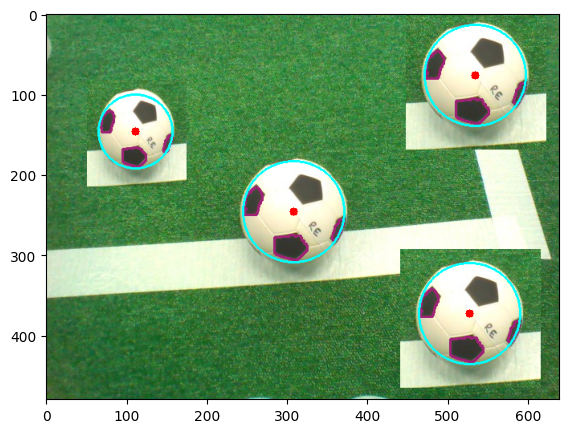

len contours0:  122
len contours:  32
unique groups:  2
radius:  31


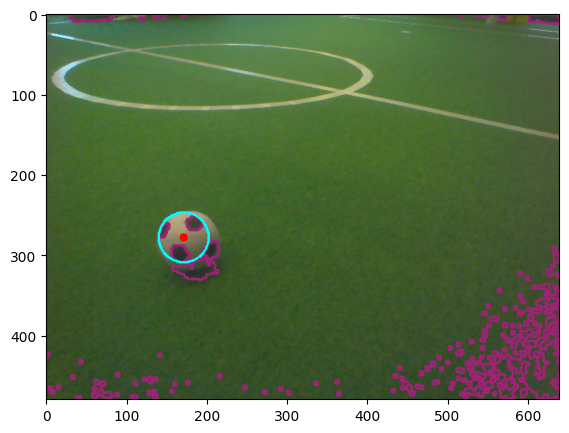

[[(171, 278), 31]]


In [41]:
proposals = get_proposals('multiple_balls.png', visual = True)
#visualize('multiple_balls.png')
proposals = get_proposals(r'Parameters_optimization/images/bs4-96.png', visual = True)

print(proposals)

In [32]:
def get_proposals_faster_gpt(image_path, visual = False):
    frame = cv2.imread(image_path)
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

    # Create masks for each channel
    h_mask = hsv[:, :, 0] < h_threshold
    s_mask = hsv[:, :, 1] < s_threshold
    v_mask = hsv[:, :, 2] < v_threshold

    # Combine masks using logical AND operations
    combined_mask = v_mask & s_mask & h_mask

    # Create the final mask
    mask_inv = np.ones_like(combined_mask, dtype=np.uint8) * 255
    mask_inv[combined_mask] = 0
    mask = cv2.bitwise_not(mask_inv)

    # Erosion and dilation
    kernel_erode = np.ones((k_erode, k_erode), np.uint8)
    kernel_dilate = np.ones((k_dilate, k_dilate), np.uint8)
    mask1 = cv2.erode(mask, kernel_erode, iterations=iterat_erode) 
    mask2 = cv2.dilate(mask1, kernel_dilate, iterations=iterat_dilate) 

    # Find contours
    contours0, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by perimeter
    contours = [contour for contour in contours0 if cv2.arcLength(contour, closed=True) > min_perimeter]

    # Center of each contour area
    points = [cv2.moments(contour) for contour in contours]
    centroids = [(int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])) for M in points]

    # Distances between contours
    distances = [calculate_distance(pair[0], pair[1]) for pair in itertools.combinations(centroids, 2)]

    # Sorted by distance
    sorted_distances = sorted(distances)

    # Group of contours
    groups = []
    for i, centroid1 in enumerate(centroids):
        group = [i]

        for j, centroid2 in enumerate(centroids[i+1:], start=i+1):
            if calculate_distance(centroid1, centroid2) < ratio_limit * sorted_distances[i]:
                group.append(j)

        groups.append(group)

    # Eliminate groups that are equal
    unique_groups = [group for i, group in enumerate(groups) if group not in groups[:i]]

    # Choosing proposals
    proposals = []
    for group in unique_groups:
        group_contours = [contours[i] for i in group]
        group_contour = np.concatenate(group_contours)
        (x, y), radius = cv2.minEnclosingCircle(group_contour)
        center = (int(x), int(y))
        radius = int(radius)
        mask_circle = np.zeros_like(frame, dtype=np.uint8)
        cv2.circle(mask_circle, center, radius, (255, 255, 255), thickness=-1)
        mask_binary = cv2.cvtColor(mask_circle, cv2.COLOR_BGR2GRAY)
        white_pixel_ratio = np.sum(frame[:, :, 2][mask_binary == 255] > white_threshold) / np.sum(mask_binary == 255)
        if white_pixel_ratio > white_pixel_ratio_threshold and radius > min_radius: 
            proposals.append((center, radius))

    # Final proposals
    final_proposals = []
    for proposal in proposals:
        (center, radius) = proposal
        cv2.circle(frame, center, radius, (0, 255, 255), 2)
        cv2.circle(frame, center, 5, (255, 0, 0), -1)
        final_proposals.append(proposal)
    if visual:
        visualize(frame)
    return final_proposals

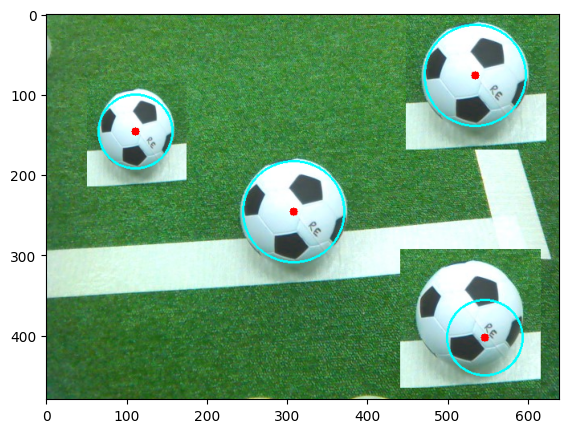

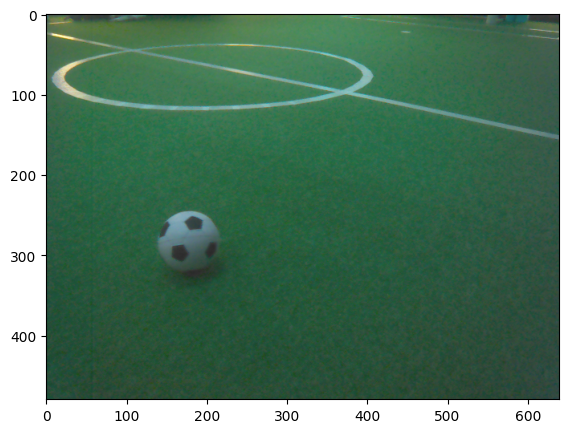

[]


In [33]:
proposals = get_proposals_faster_gpt('multiple_balls.png', visual = True)
#visualize('multiple_balls.png')
proposals = get_proposals_faster_gpt(r'Parameters_optimization/images/bs4-96.png', visual = True)

print(proposals)

In [48]:
def get_proposals_faster_gpt_me(image_path, visual = False):
    frame = cv2.imread(image_path)    
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

    # Create masks for each channel
    h_mask = hsv[:, :, 0] < h_threshold
    s_mask = hsv[:, :, 1] < s_threshold
    v_mask = hsv[:, :, 2] < v_threshold

    # Combine masks using logical AND operations
    combined_mask = v_mask & s_mask & h_mask

    # Create the final mask
    mask_inv = np.ones_like(combined_mask, dtype=np.uint8) * 255
    mask_inv[combined_mask] = 0
    mask = cv2.bitwise_not(mask_inv)

    #Erosion and dilation
    kernel_erode = np.ones((k_erode, k_erode), np.uint8)
    kernel_dilate = np.ones((k_dilate, k_dilate), np.uint8)
    mask1 = cv2.erode(mask, kernel_erode, iterat_erode) 
    mask2 = cv2.dilate(mask1, kernel_dilate, iterat_dilate) 

    # Find contours
    contours0, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #FOR VISUALIZATION: For drawing contours
    # Find contours
    contours0, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by perimeter
    contours = [contour for contour in contours0 if cv2.arcLength(contour, closed=True) > min_perimeter]


    distances = 999* np.ones((len(contours), len(contours)))

    #Center of each contour area
    points = []
    dictionary = {}
    for i in range(len(contours)):
        M1 = cv2.moments(contours[i])
        centroid1 = (int(M1['m10'] / M1['m00']), int(M1['m01'] / M1['m00']))
        points.append(centroid1)
        dictionary[str(centroid1)]= i

    # Distances between contours
    distances = [(pair[0], pair[1], calculate_distance(pair[0], pair[1])) for pair in itertools.combinations(points, 2)]


    #Sorted by distance
    sorted_distances = sorted(distances, key=lambda x: x[2])
    sorted_indices = []
    for element in sorted_distances:
        first = dictionary[str(element[0])]
        second = dictionary[str(element[1])]
        sorted_indices.append((first, second))

    #Group of contours
    groups = []
    for pair in sorted_indices:
        pair_index = sorted_indices.index(pair)
        (first, second) = pair
        add_to_group(first, second, groups, sorted_indices, sorted_distances, pair_index)
        add_to_group(second, first, groups, sorted_indices, sorted_distances, pair_index)

    #Eliminate groups that are equal. For example [1,2] and [2,1]
    unique_groups = []
    for sublist in groups:
        if not any(are_sublists_equal(sublist, existing_sublist) for existing_sublist in unique_groups):
            unique_groups.append(sublist)

    #Choosing as first proposals those that pass requirements of having enough white inside
    proposals_int = {}
    new_unique_groups = []
    for group in unique_groups:
        group_contours = [contours[i] for i in group]
        # Concatenate all contours in the group
        group_contour = np.concatenate(group_contours)

        # Calculate minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(group_contour)
        center = (int(x), int(y))
        radius = int(radius)

        # Create a mask for the area encompassed by the circle
        mask_circle = np.zeros_like(frame, dtype=np.uint8)
        cv2.circle(mask_circle, center, radius, (255, 255, 255), thickness=-1)

        # Convert the mask to binary (0 or 255)
        mask_binary = cv2.cvtColor(mask_circle, cv2.COLOR_BGR2GRAY)

        # Calculate the ratio of white pixels in the circle area
        white_pixel_ratio = np.sum(frame[:, :, 2][mask_binary == 255] > white_threshold) / np.sum(mask_binary == 255)

        # Draw the circle only if the white pixel ratio is above the threshold
        if white_pixel_ratio > white_pixel_ratio_threshold and radius > min_radius: 
            proposals_int[str(group)]=([center, radius])
            new_unique_groups.append(group)

    #Avoid overlaping of proposals and select the one with most contours on it.
    proposals = []

    already_seen = {} #which element index: where with the biggest len seen for now
    len_group = {} #index of group: len

    for index, group in enumerate(new_unique_groups):
        for element in group:
            if str(element) in already_seen:
                seen_in_group = already_seen[str(element)]

                if str(seen_in_group) in len_group and len(group) > len_group[str(seen_in_group)]:
                    already_seen[str(element)] = index #here are the largest ones
                else:
                    len_group[str(element)] = len(group)
            else:
                already_seen[str(element)] = index
                len_group[str(element)] = len(group)

    final_groups = [new_unique_groups[index] for index in set(already_seen.values())]
    for group in final_groups:
        proposals.append(proposals_int[str(group)])

    for proposal in proposals:
            [center, radius] = proposal
            if radius > min_radius:
                cv2.circle(frame, center, radius, (0, 255, 255), 2)
                cv2.circle(frame, center, 5, (255, 0, 0), -1)
                x, y = center
    if visual:
        visualize(frame)
    return proposals

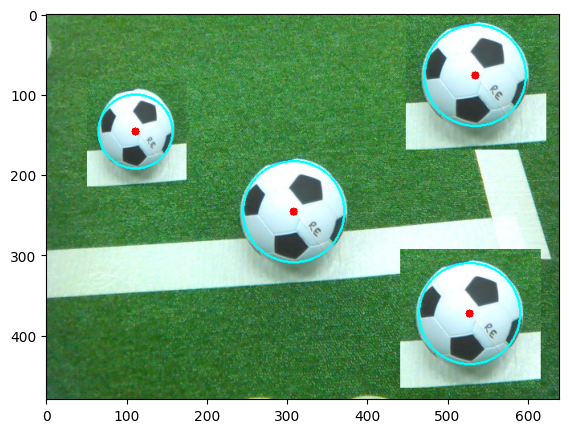

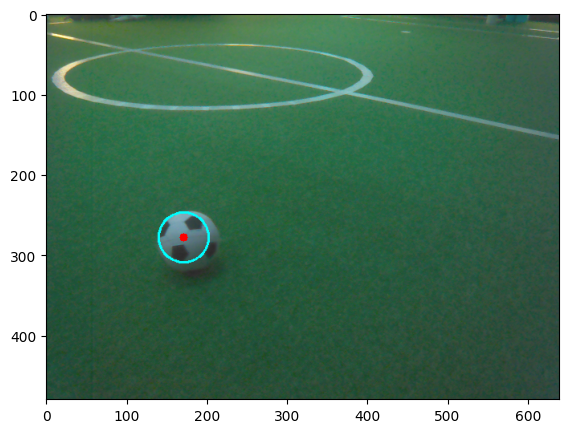

[[(171, 278), 31]]


In [49]:
proposals = get_proposals_faster_gpt_me('multiple_balls.png', visual = True)
#visualize('multiple_balls.png')
proposals = get_proposals_faster_gpt_me(r'Parameters_optimization/images/bs4-96.png', visual = True)

print(proposals)